In [1]:
!pip3 install scipy
import warnings
warnings.filterwarnings("ignore")


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import scipy.io
mat = scipy.io.loadmat('../train_32x32.mat')

In [3]:
import cv2

def convert_dataset_to_grayscale(dataset):
    gray_dataset = []
    for image in dataset:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_dataset.append(gray_image)
    return np.array(gray_dataset)

In [4]:
import numpy as np

X = mat['X']
y = mat['y']

X = np.transpose(X, (3, 0, 1, 2))
X_gray = convert_dataset_to_grayscale(X)/255
X = X_gray
y = y-1
X.shape,y.shape


((73257, 32, 32), (73257, 1))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)


X_train, X_val, y_train, y_val = train_test_split( 
    X_train, y_train, test_size=int((200/9)*0.9), random_state=1) # (200/9)* 0.9 = 0.2

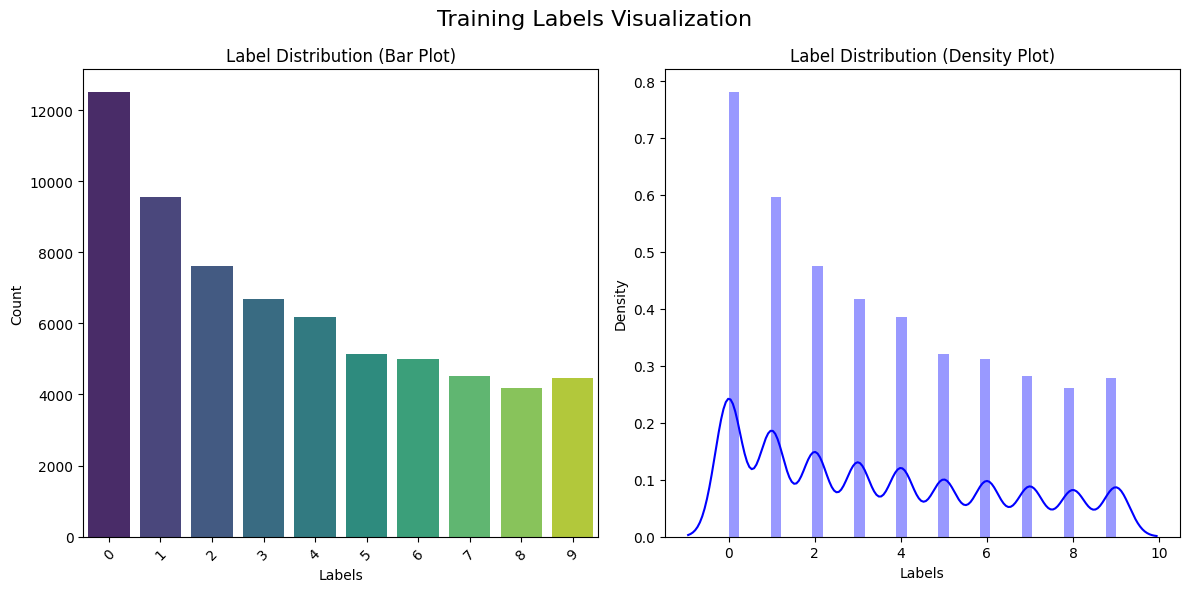

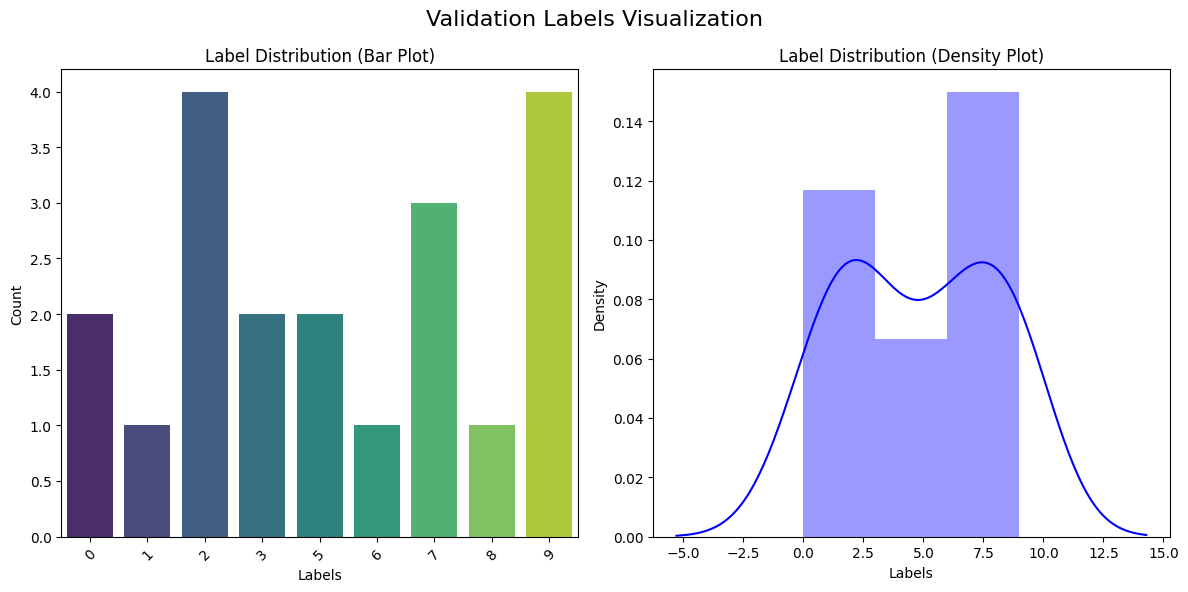

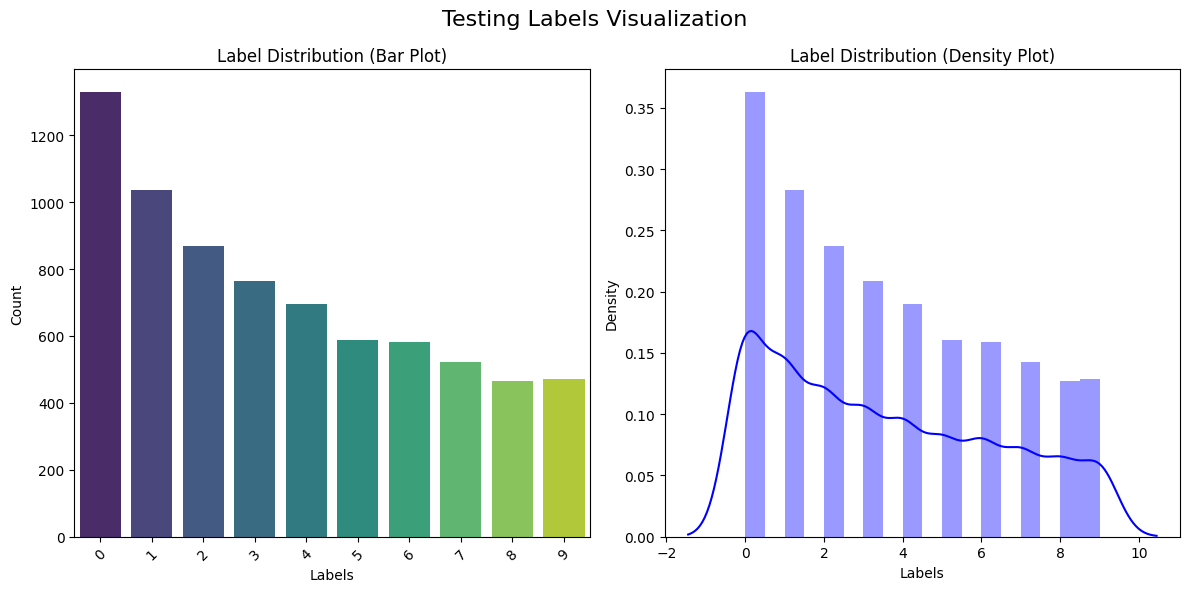

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(y,title):
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Create the bar plot on the first subplot
    sns.countplot(x=y, palette='viridis', ax=axes[0])
    axes[0].set_xlabel('Labels')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Label Distribution (Bar Plot)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Create the distribution plot on the second subplot
    sns.distplot(y, kde=True, color='blue', ax=axes[1])
    axes[1].set_xlabel('Labels')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Label Distribution (Density Plot)')
    
    # Add a title for the entire figure
    plt.suptitle(title+' Visualization', fontsize=16)
    
    plt.tight_layout()
    plt.show()

for i in [(y_train,'Training Labels'),(y_val,'Validation Labels'),(y_test,'Testing Labels')]:
    plot_distribution(i[0].flatten(),i[1])

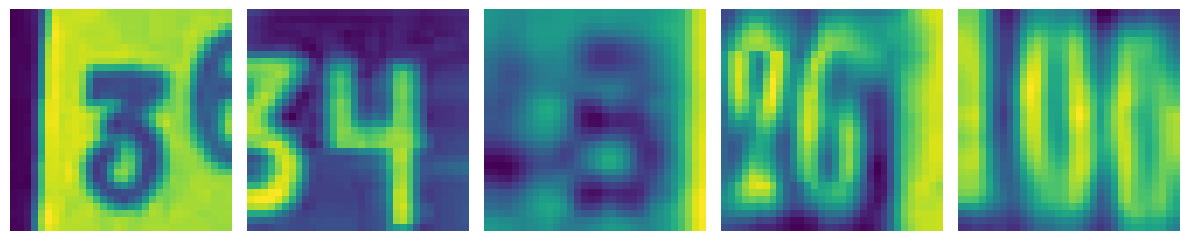

In [7]:
random_numbers = np.random.uniform(0, X_train.shape[0], 5)

fig, axes = plt.subplots(1, len(random_numbers), figsize=(12, 6))

for i, index in enumerate(random_numbers):
    ax = axes[i]
    ax.imshow(X_gray[int(index)])
    # print(y_train[int(index)])
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


### Preparing Dataset to train in Batches

In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self,X,y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        data_sample = self.data[idx]  # Get a single data sample
        label = self.labels[idx]
        return data_sample, label


training_dataset = CustomDataset(X_train,y_train)
val_dataset = CustomDataset(X_val,y_val)
test_dataset = CustomDataset(X_test,y_test)

In [12]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [13]:
# Testing cell

next(iter(train_dataloader))[0].shape

torch.Size([128, 32, 32])

### 1. ReLU

In [48]:
#creating model class

class Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    
    def forward(self, X):
        return self.layers(X)


In [49]:
model = Model(1024,256,10).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.1)

In [50]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [51]:
import matplotlib.pyplot as plt

def plot_loss_graph(loss, epochs,loss_type):
    x_axis = range(epochs)
    plt.figure(figsize=(8, 6))
    plt.plot(x_axis, loss, label=loss_type, color='b', marker='o', linestyle='-')
    plt.title(loss_type)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_loss_graph(train_loss_list, num_epochs)


In [52]:
## defining function abstraction for training and testing functionalities

def training_step(model,dataloader,X,y,train_loss_list):
    train_loss = 0
    
    for batch,(X,y) in enumerate(dataloader):
        
        y_pred = model(X)
        
        y  = torch.squeeze(y)
#         y = y.long()
        loss = loss_fn(y_pred, y)  
        train_loss += loss
        train_acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

        if batch%520 == 0:
            print(f"Looked at {batch*len(X)}/{len(dataloader)} samples.")

    train_loss /=len(train_dataloader)

    print(f"Training loss : {train_loss} | Train acc: {train_acc:.4f}| ")
    train_loss_list.append(train_loss.item())

def testing_step(model,dataloader,X,y,test_loss_list,accuracy_list):
    test_loss = 0
    test_acc = 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in dataloader:
            test_pred = model(X)
            y = torch.squeeze(y)
            test_loss+=loss_fn(test_pred,y)
            test_acc += accuracy_fn(y_true=y,y_pred = test_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    print(f"Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}")
    test_loss_list.append(test_loss.item())
    accuracy_list.append(test_acc)


In [53]:
torch.manual_seed(42)

EPOCHS = 20

train_loss = 0

train_loss_list = []
test_loss_list_train = []
accuracy_list_train = []

val_loss_list = []
test_loss_list_val = []
accuracy_list_val = []

# training and testing loop
for epoch in tqdm(range(EPOCHS)):
    training_step(model,train_dataloader,X_train,y_train,train_loss_list)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_train,accuracy_list_train)

#training and validation loop
EPOCHS = 6
for epoch in tqdm(range(EPOCHS)):
    training_step(model,val_dataloader,X_val,y_val,val_loss_list)
    testing_step(model,test_dataloader,X_test,y_test,test_loss_list_val,accuracy_list_val)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Looked at 0/515 samples.


  5%|██▏                                         | 1/20 [00:01<00:35,  1.89s/it]

Training loss : 2.1996766024519343 | Train acc: 31.0924| 
Test loss : 2.0652 | Test acc : 29.5079
Looked at 0/515 samples.


 10%|████▍                                       | 2/20 [00:03<00:34,  1.93s/it]

Training loss : 1.9292294105825467 | Train acc: 38.6555| 
Test loss : 1.8118 | Test acc : 37.6742
Looked at 0/515 samples.


 15%|██████▌                                     | 3/20 [00:05<00:32,  1.93s/it]

Training loss : 1.6860105821653715 | Train acc: 52.9412| 
Test loss : 1.6045 | Test acc : 48.7347
Looked at 0/515 samples.


 20%|████████▊                                   | 4/20 [00:07<00:29,  1.85s/it]

Training loss : 1.5350675979867934 | Train acc: 50.4202| 
Test loss : 1.4458 | Test acc : 52.6248
Looked at 0/515 samples.


 25%|███████████                                 | 5/20 [00:09<00:27,  1.83s/it]

Training loss : 1.448199552289094 | Train acc: 63.8655| 
Test loss : 1.4088 | Test acc : 53.6889
Looked at 0/515 samples.


 30%|█████████████▏                              | 6/20 [00:11<00:25,  1.80s/it]

Training loss : 1.3935902452709246 | Train acc: 57.1429| 
Test loss : 1.3280 | Test acc : 55.7399
Looked at 0/515 samples.


 35%|███████████████▍                            | 7/20 [00:12<00:23,  1.79s/it]

Training loss : 1.357939189774574 | Train acc: 55.4622| 
Test loss : 1.3298 | Test acc : 56.6352
Looked at 0/515 samples.


 40%|█████████████████▌                          | 8/20 [00:14<00:21,  1.79s/it]

Training loss : 1.338287854239113 | Train acc: 56.3025| 
Test loss : 1.2958 | Test acc : 57.8242
Looked at 0/515 samples.


 45%|███████████████████▊                        | 9/20 [00:16<00:19,  1.79s/it]

Training loss : 1.3004284861991364 | Train acc: 65.5462| 
Test loss : 1.2554 | Test acc : 60.0638
Looked at 0/515 samples.


 50%|█████████████████████▌                     | 10/20 [00:18<00:17,  1.79s/it]

Training loss : 1.2535994280822649 | Train acc: 63.0252| 
Test loss : 1.2118 | Test acc : 61.9127
Looked at 0/515 samples.


 55%|███████████████████████▋                   | 11/20 [00:20<00:16,  1.81s/it]

Training loss : 1.2091743269078778 | Train acc: 69.7479| 
Test loss : 1.1732 | Test acc : 64.9533
Looked at 0/515 samples.


 60%|█████████████████████████▊                 | 12/20 [00:21<00:14,  1.81s/it]

Training loss : 1.145086319172705 | Train acc: 67.2269| 
Test loss : 1.1910 | Test acc : 62.8080
Looked at 0/515 samples.


 65%|███████████████████████████▉               | 13/20 [00:23<00:12,  1.82s/it]

Training loss : 1.106300101013678 | Train acc: 66.3866| 
Test loss : 1.0983 | Test acc : 66.0138
Looked at 0/515 samples.


 70%|██████████████████████████████             | 14/20 [00:25<00:11,  1.84s/it]

Training loss : 1.0836432254735 | Train acc: 69.7479| 
Test loss : 1.1096 | Test acc : 64.4109
Looked at 0/515 samples.


 75%|████████████████████████████████▎          | 15/20 [00:27<00:09,  1.82s/it]

Training loss : 1.0486230009891302 | Train acc: 67.2269| 
Test loss : 1.0860 | Test acc : 65.4382
Looked at 0/515 samples.


 80%|██████████████████████████████████▍        | 16/20 [00:29<00:07,  1.81s/it]

Training loss : 1.0272151099923155 | Train acc: 70.5882| 
Test loss : 1.0828 | Test acc : 65.0072
Looked at 0/515 samples.


 85%|████████████████████████████████████▌      | 17/20 [00:30<00:05,  1.82s/it]

Training loss : 1.0113710023336773 | Train acc: 61.3445| 
Test loss : 1.1103 | Test acc : 65.9770
Looked at 0/515 samples.


 90%|██████████████████████████████████████▋    | 18/20 [00:32<00:03,  1.82s/it]

Training loss : 0.9894182662783922 | Train acc: 69.7479| 
Test loss : 0.9930 | Test acc : 69.4962
Looked at 0/515 samples.


 95%|████████████████████████████████████████▊  | 19/20 [00:34<00:01,  1.84s/it]

Training loss : 0.9663492882641399 | Train acc: 62.1849| 
Test loss : 1.0638 | Test acc : 65.8019
Looked at 0/515 samples.


100%|███████████████████████████████████████████| 20/20 [00:36<00:00,  1.84s/it]


Training loss : 0.958778252355625 | Train acc: 64.7059| 
Test loss : 1.0183 | Test acc : 67.5934


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Looked at 0/1 samples.
Training loss : 0.0021922622965638567 | Train acc: 70.0000| 


 17%|███████▌                                     | 1/6 [00:00<00:00,  5.23it/s]

Test loss : 1.8134 | Test acc : 47.8511
Looked at 0/1 samples.
Training loss : 0.0019319609477908705 | Train acc: 70.0000| 


 33%|███████████████                              | 2/6 [00:00<00:00,  5.23it/s]

Test loss : 1.9955 | Test acc : 50.5056
Looked at 0/1 samples.
Training loss : 0.0026164022063513478 | Train acc: 75.0000| 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.15it/s]

Test loss : 1.2904 | Test acc : 61.1512


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.50it/s]

Looked at 0/1 samples.
Training loss : 0.002044332983318497 | Train acc: 75.0000| 
Test loss : 1.6425 | Test acc : 50.1562
Looked at 0/1 samples.
Training loss : 0.001649033210924679 | Train acc: 80.0000| 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.71it/s]

Test loss : 1.2245 | Test acc : 59.4504
Looked at 0/1 samples.
Training loss : 0.0013746020449307715 | Train acc: 85.0000| 
Test loss : 1.3828 | Test acc : 55.4023


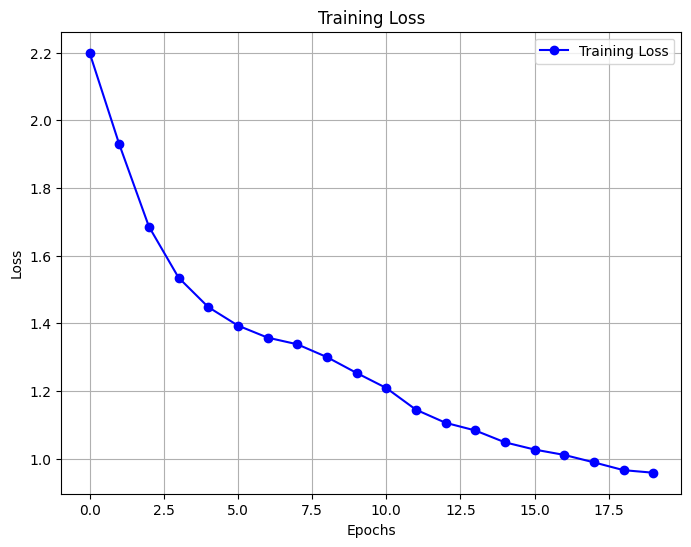

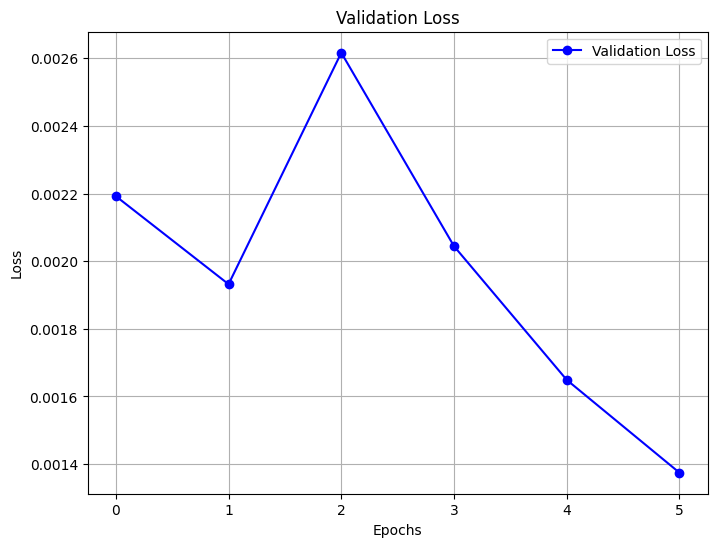

In [55]:
plot_loss_graph(train_loss_list,20,"Training Loss")

plot_loss_graph(val_loss_list,6,"Validation Loss")

In [82]:
# Code to find misclassified images

map = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}  # Assuming you have 10 classes

model.eval()

with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model(X)
        y = torch.squeeze(y)
        test_loss += loss_fn(test_pred, y)
        
        # Get the predicted labels and true labels
        predicted_labels = test_pred.argmax(dim=1)
        
        # Find the misclassified samples
        misclassified_indices = (predicted_labels != y).nonzero().squeeze()
        for index in misclassified_indices:
            true_label = y[index].item()
            true_label+=1
            predicted_label = predicted_labels[index].item() + 1
            if(len(map[true_label])<3):
                map[true_label].append((X[index], predicted_label))

# for i in range(1,11):
#     print(len(map[i]))

Class 1 Misclassified Examples:


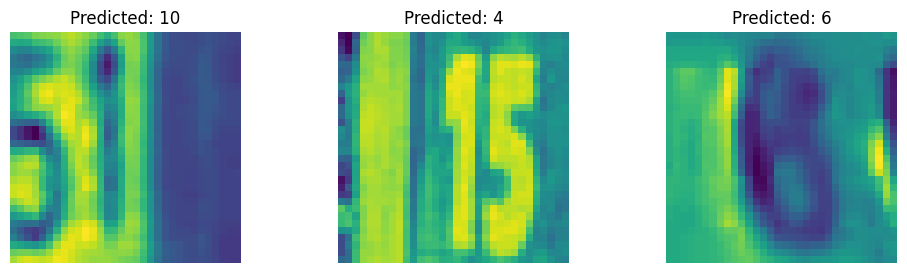

Class 2 Misclassified Examples:


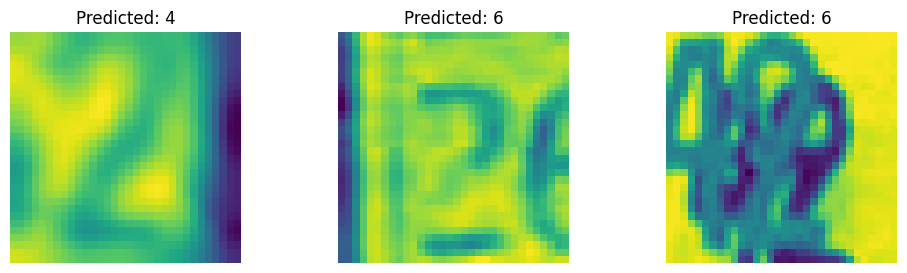

Class 3 Misclassified Examples:


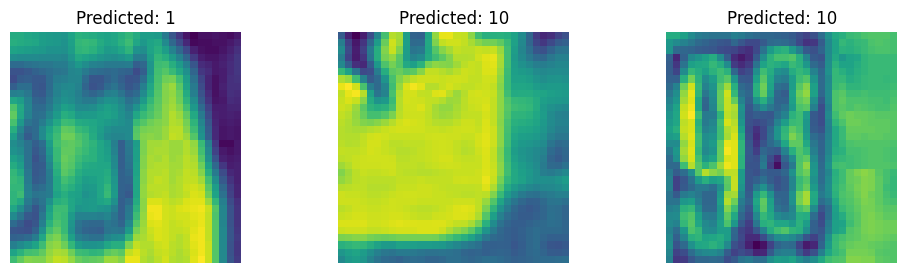

Class 4 Misclassified Examples:


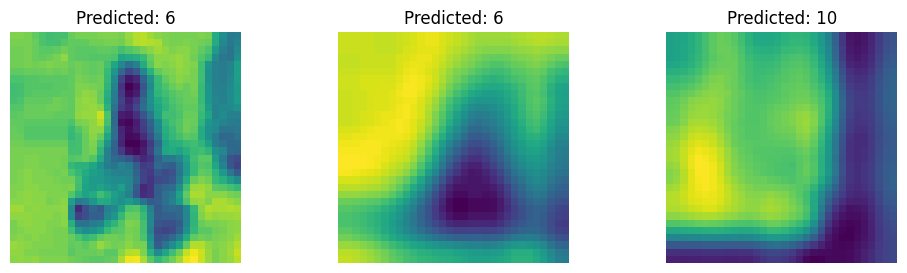

Class 5 Misclassified Examples:


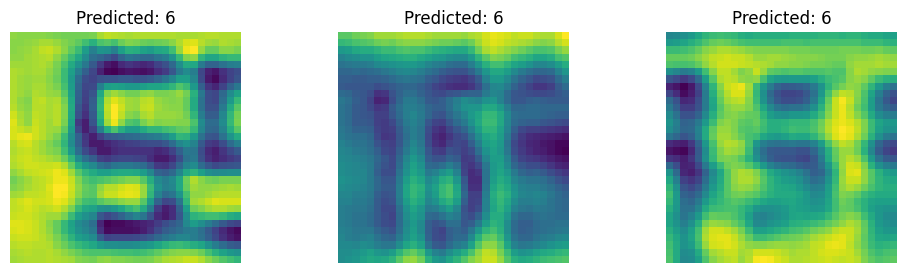

Class 6 Misclassified Examples:


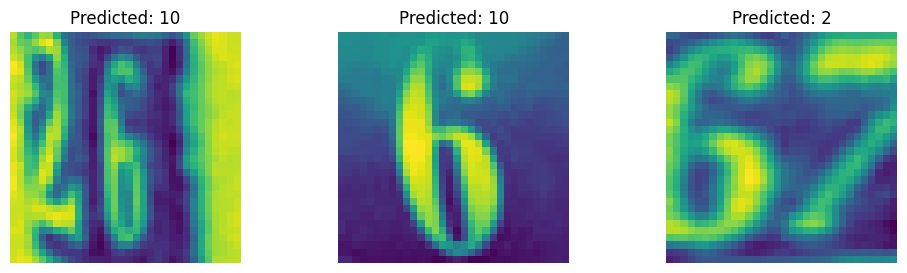

Class 7 Misclassified Examples:


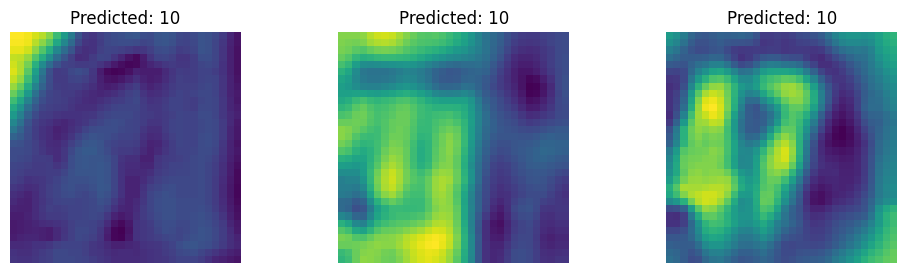

Class 8 Misclassified Examples:


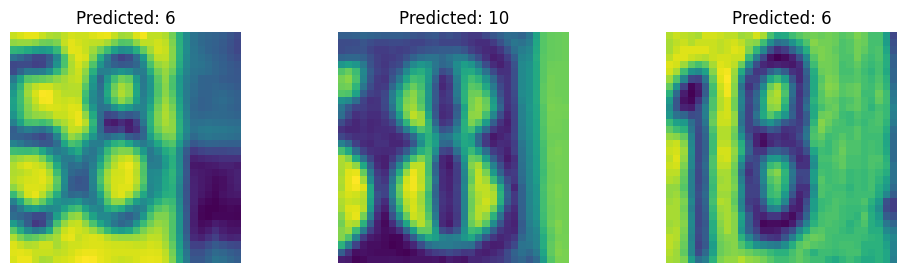

Class 9 Misclassified Examples:


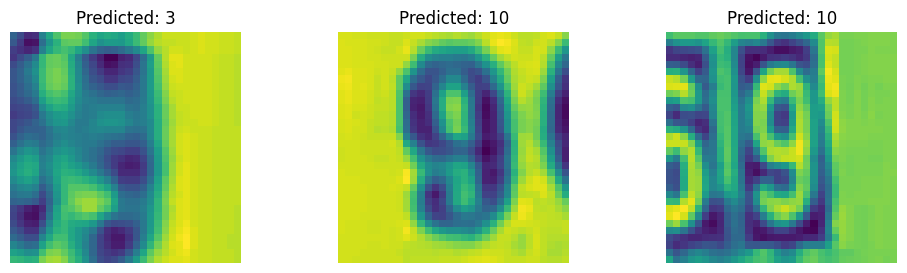

Class 10 Misclassified Examples:


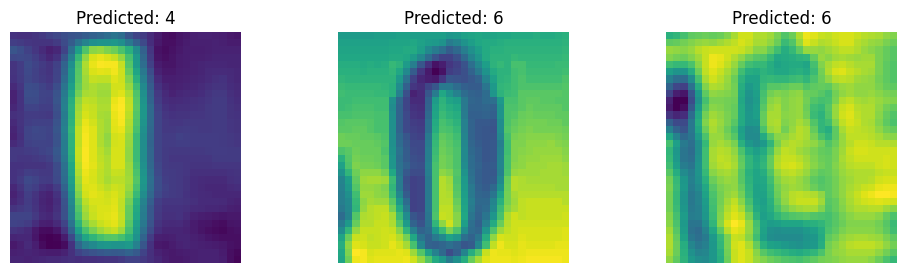

In [83]:
# Visualizing misclassified samples

for true_label, misclassified_samples in map.items():
    print(f"Class {true_label} Misclassified Examples:")
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(12, 3))
    for i, (flattened_image, predicted_label) in enumerate(misclassified_samples):
        reshaped_image = flattened_image.reshape(32,32)
        axes[i].imshow(reshaped_image)
        axes[i].set_title(f"Predicted: {predicted_label}")
        axes[i].axis('off')

    plt.show()
